In [374]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import rasterio as rio
import seaborn as sns
import os, glob
from tifffile import imsave
import cv2
import tarfile
import pyproj as proj
from osgeo import gdal
import rasterio
import itertools
import os
import csv
from scipy.interpolate import griddata
#from arcpy import env
from rasterstats import zonal_stats
%matplotlib inline

path = os.getcwd()

In [375]:
path='E:\program'
os.chdir(path)

# extract files and make csv-files

In [31]:
#extract files to csv
import pandas
inputFolder=r'CMIP\tar_open\West_Coast'
for i in range(3,len(os.listdir(inputFolder))):
    model_name=os.listdir(inputFolder)[i]
    inputPath = os.path.join(r'CMIP\tar_open\West_Coast', model_name , 'ssp585','PrecipData')
    df = pandas.read_csv(inputPath,header=None)
    df['split'] = df[0].str.split(' ')
    amount_rows=len(df['split'])
    amount_columns=len(df['split'][0])
    list_columns=[]
    for i in range(amount_columns):
        list_columns.append(str(i))
    df2=pd.DataFrame(columns=list_columns)
    for i in range(amount_rows):
        df2.loc[i]=df['split'][i]
    outputPath = os.path.join(r'CMIP\csv_files_585', model_name + '-ssp585' +'.csv')
    df2.to_csv(outputPath, index = False)

KeyboardInterrupt: 

# open csv files and select the region of interest 

In [154]:
#creates usable df from csv
def func1_usable_df(df3):
    df3=df3.fillna(0)
    df3=df3.iloc[1:]
    df3.iloc[:,0]=df3.iloc[:,0].astype(int)
    df3.iloc[:,1]=df3.iloc[:,1].astype(int)
    df3.iloc[:,2]=df3.iloc[:,2].astype(int)
    #make dates as index
    df3.iloc[:,0]=df3.iloc[:,0].astype(str)
    df3.iloc[:,1]=df3.iloc[:,1].astype(str)
    df3.iloc[:,2]=df3.iloc[:,2].astype(str)
    df3.iloc[:,0]=df3.iloc[:,0]+'-'+df3.iloc[:,1]+'-'+df3.iloc[:,2]
    df3=df3.set_index(0)
    df3 = df3.drop(columns=[1, 2]) 
    df3.iloc[0,0]=0
    df3.iloc[1,0]=0
    #remove useless columns outside mumbai extent
    df3.iloc[0]=df3.iloc[0].astype(float)
    df3.iloc[1]=df3.iloc[1].astype(float)
    df3 = df3.drop(df3.columns[df3.iloc[0] >74.05],axis=1)
    df3 = df3.drop(df3.columns[df3.iloc[1] <18.3],axis=1)
    df3 = df3.drop(df3.columns[df3.iloc[1] >20.2],axis=1) 
    for i in range(2016,2101,4):
        i=str(i)
        i=i+'-2-29'
        try:
            df3=df3.drop([i])
        except:
            pass
    return df3

In [132]:
#executes func1_usable_df
inputFolder=r'CMIP\csv_files_370'
dictionary_370={}
for model_name in os.listdir(inputFolder):
    inputPath = os.path.join(inputFolder, model_name)
    parts = model_name.split(".")
    df_name= parts[0]
    df=pd.read_csv(inputPath,header=None)
    dictionary_370[df_name]=func1_usable_df(df) 
#df3=pd.read_csv(r'CMIP\csv_files\.csv')
#df4=func1_usable_df(df3)

In [205]:
#executes func1_usable_df
inputFolder=r'CMIP\csv_files_585'
dictionary_585={}
for model_name in os.listdir(inputFolder):
    inputPath = os.path.join(inputFolder, model_name)
    parts = model_name.split(".")
    df_name= parts[0]
    df=pd.read_csv(inputPath,header=None)
    dictionary_585[df_name]=func1_usable_df(df) 
#df3=pd.read_csv(r'CMIP\csv_files\.csv')
#df4=func1_usable_df(df3)

In [10]:
#takes model average
#df4=(dictionary_585['ACCESS-CM2-ssp585']+dictionary_585['ACCESS-ESM1-5-ssp585']
#     +dictionary_585['BCC-CSM2-MR-ssp585']
#     +dictionary_585['CanESM5-ssp585']+dictionary_585['EC-Earth3-ssp585']
#     +dictionary_585['EC-Earth3-Veg-ssp585']+dictionary_585['INM-CM4-8-ssp585']
#     +dictionary_585['INM-CM5-0-ssp585']+dictionary_585['MPI-ESM1-2-HR-ssp585']
#     + dictionary_585['MPI-ESM1-2-LR-ssp585']+ dictionary_585['MRI-ESM2-0-ssp585']
#     +dictionary_585['NorESM2-LM-ssp585']+dictionary_585['NorESM2-MM-ssp585'])*(1/13)

In [206]:
df4=dictionary_585['CanESM5-ssp585']

In [141]:
df4

,4,5,6,7,11,12,13,14,15,16,...,29,30,31,32,33,34,35,47,48,49
0,,,,,,,,,,,,,,,,,,,,,
0-0-0,72.875,72.875,72.875,72.875,73.125,73.125,73.125,73.125,73.125,73.125,...,73.375,73.375,73.375,73.375,73.375,73.375,73.375,73.625,73.625,73.625
0-0-0,19.375,19.625,19.875,20.125,18.375,18.625,18.875,19.125,19.375,19.625,...,18.625,18.875,19.125,19.375,19.625,19.875,20.125,19.375,19.625,20.125
2015-1-1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.410,0.000,0.000,0.230
2015-1-2,3.460,4.080,4.540,4.340,3.420,4.990,4.670,4.360,4.130,5.310,...,4.840,4.810,4.480,4.810,6.600,7.150,5.900,3.310,4.480,3.390
2015-1-3,3.870,4.520,4.840,4.460,4.170,5.730,5.220,4.520,4.100,5.020,...,5.130,4.780,4.210,4.100,5.200,5.500,4.420,2.760,3.360,2.250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2100-12-27,30.480,36.970,41.340,44.470,14.720,21.510,26.230,28.550,31.350,38.430,...,17.560,21.930,24.610,29.620,39.460,39.900,37.990,18.040,25.340,22.520
2100-12-28,30.020,32.470,33.330,32.990,30.240,34.180,32.590,31.010,30.050,33.710,...,26.250,26.080,25.690,27.540,33.910,32.070,28.490,16.990,21.750,16.880
2100-12-29,30.620,33.540,34.690,34.770,30.730,35.160,34.390,33.480,32.870,37.160,...,28.380,28.720,29.150,31.910,39.850,38.190,34.720,21.590,28.550,23.750


In [142]:
df4.loc['2015-7-30']

4     113.83
5     114.94
6     115.80
7     111.39
11    136.65
12    140.18
13    137.03
14    122.66
15    116.16
16    121.06
17    121.20
18    114.60
28    121.06
29    116.33
30    115.34
31    103.32
32    104.12
33    115.16
34    109.94
35    101.75
47     67.78
48     80.33
49     65.87
Name: 2015-7-30, dtype: float64

In [68]:
df4.iloc[0].min()

72.875

# Rainfall overview of the models

Step1: Divide in three time frames: 2015-2040 (26 years), 2041-2070 (30 years), 2071-2100 (30 years) 
Step2: Average over space to get one single precipitation value per day
Step3: Take the top 30 precipitation values per year
Step4: make a list of all the top 30 precipitation values for a time frame
Step5: Make a histogram for the three time frames

In [35]:
#rainfall first 26 years (2015-2040)
def func_max_begin_2(dict_name):
    dictionary_name=dict_name
    c=pd.DataFrame()
    lijstje2=[]
    for i in range(2,9492,365):
        j=i+365
        df1=dictionary_370[dict_name][i:j]
        df2=df1.mean(axis=1)
        df3=df2.nlargest(n=30).to_list()
        lijstje2.append(df3)
    flat_list = []
    for sublist in lijstje2:
        for item in sublist:
            flat_list.append(item)
    return flat_list

In [36]:
#rainfall first 26 years (2041-2070)
def func_max_begin_3(dict_name):
    dictionary_name=dict_name
    c=pd.DataFrame()
    lijstje2=[]
    for i in range(9492,20442,365):
        j=i+365
        df1=dictionary_370[dict_name][i:j]
        df2=df1.mean(axis=1)
        df3=df2.nlargest(n=30).to_list()
        lijstje2.append(df3)
    flat_list = []
    for sublist in lijstje2:
        for item in sublist:
            flat_list.append(item)
    return flat_list

In [37]:
#rainfall first 26 years (2070-2100)
def func_max_begin_4(dict_name):
    dictionary_name=dict_name
    c=pd.DataFrame()
    lijstje2=[]
    for i in range(20442,31392,365):
        j=i+365
        df1=dictionary_370[dict_name][i:j]
        df2=df1.mean(axis=1)
        df3=df2.nlargest(n=30).to_list()
        lijstje2.append(df3)
    flat_list = []
    for sublist in lijstje2:
        for item in sublist:
            flat_list.append(item)
    return flat_list

370

In [38]:
a_1=func_max_begin_2('ACCESS-CM2-ssp370')
a_2=func_max_begin_3('ACCESS-CM2-ssp370')
a_3=func_max_begin_4('ACCESS-CM2-ssp370')
b_1=func_max_begin_2('ACCESS-ESM1-5-ssp370')
b_2=func_max_begin_3('ACCESS-ESM1-5-ssp370')
b_3=func_max_begin_4('ACCESS-ESM1-5-ssp370')
c_1=func_max_begin_2('BCC-CSM2-MR-ssp370')
c_2=func_max_begin_3('BCC-CSM2-MR-ssp370')
c_3=func_max_begin_4('BCC-CSM2-MR-ssp370')
d_1=func_max_begin_2('CanESM5-ssp370')
d_2=func_max_begin_3('CanESM5-ssp370')
d_3=func_max_begin_4('CanESM5-ssp370')
e_1=func_max_begin_2('EC-Earth3-ssp370')
e_2=func_max_begin_3('EC-Earth3-ssp370')
e_3=func_max_begin_4('EC-Earth3-ssp370')
f_1=func_max_begin_2('EC-Earth3-Veg-ssp370')
f_2=func_max_begin_3('EC-Earth3-Veg-ssp370')
f_3=func_max_begin_4('EC-Earth3-Veg-ssp370')
g_1=func_max_begin_2('INM-CM4-8-ssp370')
g_2=func_max_begin_3('INM-CM4-8-ssp370')
g_3=func_max_begin_4('INM-CM4-8-ssp370')
h_1=func_max_begin_2('INM-CM5-0-ssp370')
h_2=func_max_begin_3('INM-CM5-0-ssp370')
h_3=func_max_begin_4('INM-CM5-0-ssp370')
i_1=func_max_begin_2('MPI-ESM1-2-HR-ssp370')
i_2=func_max_begin_3('MPI-ESM1-2-HR-ssp370')
i_3=func_max_begin_4('MPI-ESM1-2-HR-ssp370')
j_1=func_max_begin_2('MPI-ESM1-2-LR-ssp370')
j_2=func_max_begin_3('MPI-ESM1-2-LR-ssp370')
j_3=func_max_begin_4('MPI-ESM1-2-LR-ssp370')
k_1=func_max_begin_2('MRI-ESM2-0-ssp370')
k_2=func_max_begin_3('MRI-ESM2-0-ssp370')
k_3=func_max_begin_4('MRI-ESM2-0-ssp370')
l_1=func_max_begin_2('NorESM2-LM-ssp370')
l_2=func_max_begin_3('NorESM2-LM-ssp370')
l_3=func_max_begin_4('NorESM2-LM-ssp370')
m_1=func_max_begin_2('NorESM2-MM-ssp370')
m_2=func_max_begin_3('NorESM2-MM-ssp370')
m_3=func_max_begin_4('NorESM2-MM-ssp370')
a=[a_1,a_2,a_3]
b=[b_1,b_2,b_3]
c=[c_1,c_2,c_3]
d=[d_1,d_2,d_3]
e=[e_1,e_2,e_3]
f=[f_1,f_2,f_3]
g=[g_1,g_2,g_3]
h=[h_1,h_2,h_3]
i=[i_1,i_2,i_3]
j=[j_1,j_2,j_3]
k=[k_1,k_2,k_3]
l=[l_1,l_2,l_3]
m=[m_1,m_2,m_3]
letters=[a,b,c,d,e,f,g,h,i,j,k,l,m]

<ipython-input-39-b99f9d86939b>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-39-b99f9d86939b>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-39-b99f9d86939b>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


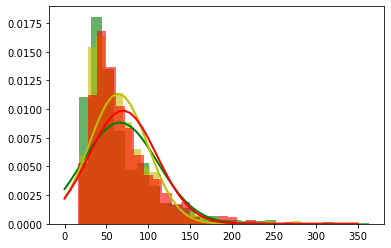

<ipython-input-39-b99f9d86939b>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-39-b99f9d86939b>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-39-b99f9d86939b>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


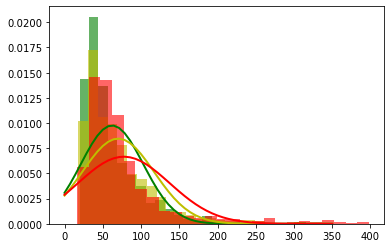

<ipython-input-39-b99f9d86939b>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-39-b99f9d86939b>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-39-b99f9d86939b>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


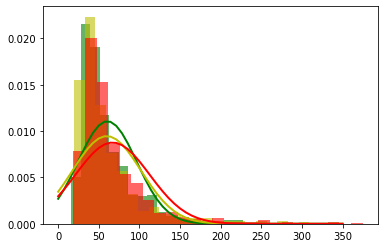

<ipython-input-39-b99f9d86939b>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-39-b99f9d86939b>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-39-b99f9d86939b>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


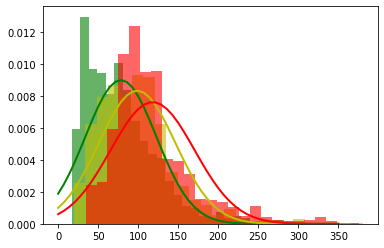

<ipython-input-39-b99f9d86939b>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-39-b99f9d86939b>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-39-b99f9d86939b>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


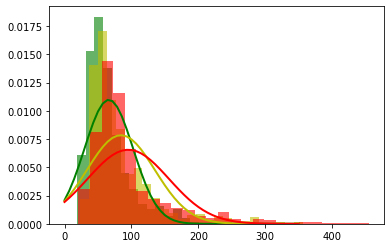

<ipython-input-39-b99f9d86939b>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-39-b99f9d86939b>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-39-b99f9d86939b>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


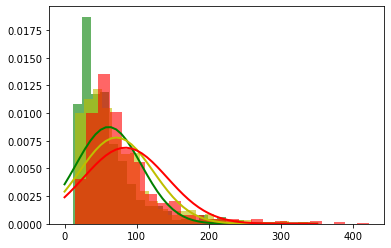

<ipython-input-39-b99f9d86939b>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-39-b99f9d86939b>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-39-b99f9d86939b>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


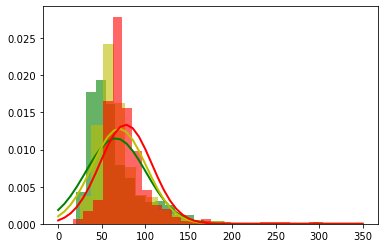

<ipython-input-39-b99f9d86939b>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-39-b99f9d86939b>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-39-b99f9d86939b>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


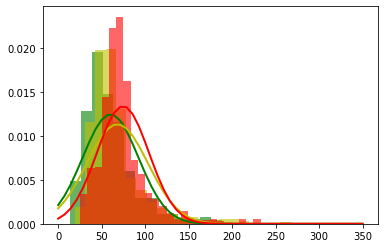

<ipython-input-39-b99f9d86939b>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-39-b99f9d86939b>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-39-b99f9d86939b>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


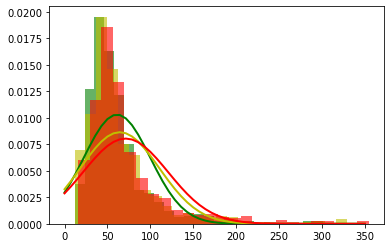

<ipython-input-39-b99f9d86939b>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-39-b99f9d86939b>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-39-b99f9d86939b>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


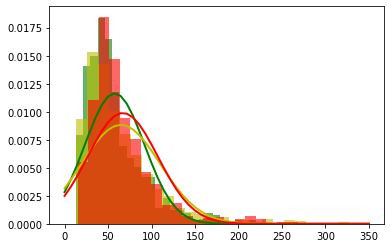

<ipython-input-39-b99f9d86939b>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-39-b99f9d86939b>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-39-b99f9d86939b>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


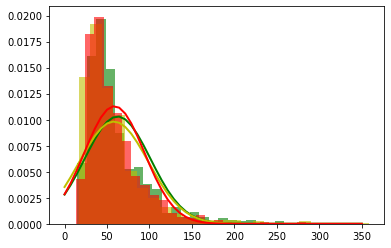

<ipython-input-39-b99f9d86939b>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-39-b99f9d86939b>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-39-b99f9d86939b>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


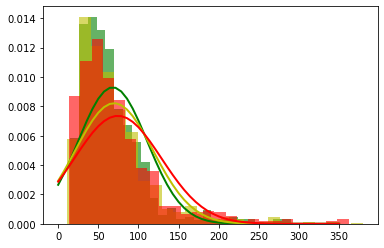

<ipython-input-39-b99f9d86939b>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-39-b99f9d86939b>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-39-b99f9d86939b>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


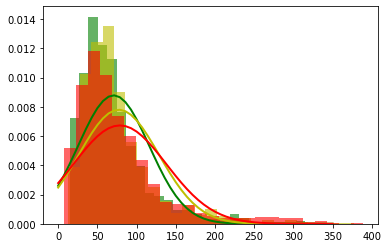

In [39]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

mu_1=np.zeros([13,3])
std_1=np.zeros([13,3])
for count,i in enumerate(letters):
    var1=i[0]
    var2=i[1]
    var3=i[2]
    # Plot the histogram.
    plt.hist(var1, bins=25, density=True, alpha=0.6, color='g')
    plt.hist(var2, bins=25, density=True, alpha=0.6, color='y')
    plt.hist(var3, bins=25, density=True, alpha=0.6, color='r')
    # Fit a normal distribution to the data:
    mu1, std1 = norm.fit(var1)
    mu2, std2 = norm.fit(var2)
    mu3, std3 = norm.fit(var3)
    mu_1[count]=[mu1,mu2,mu3]
    std_1[count]=[std1,std2,std3]
    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(0, 350)
    p1 = norm.pdf(x, mu1, std1)
    p2 = norm.pdf(x, mu2, std2)
    p3 = norm.pdf(x, mu3, std3)
    plt.plot(x, p1, 'k', linewidth=2,color='g')
    plt.plot(x, p2, 'k', linewidth=2,color='y')
    plt.plot(x, p3, 'k', linewidth=2,color='r')
    count2=str(count)
    plt.savefig('model_370_'+count2+'.png')
    plt.show()

In [40]:
mu_1

array([[ 66.06196042,  64.15394638,  69.69732319],
       [ 62.11206912,  70.09769469,  77.48680048],
       [ 60.55406466,  59.81081546,  66.94638309],
       [ 78.35625697,  98.6455285 , 117.96066039],
       [ 66.16358082,  84.24353913,  95.22134251],
       [ 61.08470513,  71.85627778,  84.25883913],
       [ 66.21109643,  70.17088937,  77.70833333],
       [ 60.23877982,  68.10060725,  74.5028314 ],
       [ 61.16572018,  64.37291836,  71.13132174],
       [ 57.65664326,  64.72787536,  66.97261739],
       [ 62.40183501,  58.06749034,  58.69928841],
       [ 67.92549833,  69.71266039,  74.42916908],
       [ 70.81574638,  77.42072271,  78.72764203]])

In [41]:
std_1

array([[45.15077403, 35.18360324, 40.37835667],
       [40.87586178, 47.16463234, 59.88493405],
       [36.05379499, 42.17105747, 45.50423279],
       [44.3294077 , 47.88031546, 52.38370459],
       [36.3580313 , 50.89850503, 60.90950444],
       [45.59742695, 51.16889487, 58.02039423],
       [34.64121516, 31.15871455, 29.88288529],
       [32.04700303, 35.22153182, 29.81077061],
       [38.69804984, 46.13077149, 49.57280951],
       [34.28419334, 45.181514  , 40.32727656],
       [38.69525734, 40.61335038, 35.31106831],
       [42.91155839, 48.54274144, 54.24132856],
       [45.39093824, 51.12510991, 59.27299722]])

585

In [42]:
#rainfall first 26 years (2015-2040)
def func_max_begin_2(dict_name):
    dictionary_name=dict_name
    c=pd.DataFrame()
    lijstje2=[]
    for i in range(2,9492,365):
        j=i+365
        df1=dictionary_585[dict_name][i:j]
        df2=df1.mean(axis=1)
        df3=df2.nlargest(n=30).to_list()
        lijstje2.append(df3)
    flat_list = []
    for sublist in lijstje2:
        for item in sublist:
            flat_list.append(item)
    return flat_list

In [43]:
#rainfall first 26 years (2041-2070)
def func_max_begin_3(dict_name):
    dictionary_name=dict_name
    c=pd.DataFrame()
    lijstje2=[]
    for i in range(9492,20442,365):
        j=i+365
        df1=dictionary_585[dict_name][i:j]
        df2=df1.mean(axis=1)
        df3=df2.nlargest(n=30).to_list()
        lijstje2.append(df3)
    flat_list = []
    for sublist in lijstje2:
        for item in sublist:
            flat_list.append(item)
    return flat_list

In [44]:
#rainfall first 26 years (2070-2100)
def func_max_begin_4(dict_name):
    dictionary_name=dict_name
    c=pd.DataFrame()
    lijstje2=[]
    for i in range(20442,31392,365):
        j=i+365
        df1=dictionary_585[dict_name][i:j]
        df2=df1.mean(axis=1)
        df3=df2.nlargest(n=30).to_list()
        lijstje2.append(df3)
    flat_list = []
    for sublist in lijstje2:
        for item in sublist:
            flat_list.append(item)
    return flat_list

In [45]:
a_1=func_max_begin_2('ACCESS-CM2-ssp585')
a_2=func_max_begin_3('ACCESS-CM2-ssp585')
a_3=func_max_begin_4('ACCESS-CM2-ssp585')
b_1=func_max_begin_2('ACCESS-ESM1-5-ssp585')
b_2=func_max_begin_3('ACCESS-ESM1-5-ssp585')
b_3=func_max_begin_4('ACCESS-ESM1-5-ssp585')
c_1=func_max_begin_2('BCC-CSM2-MR-ssp585')
c_2=func_max_begin_3('BCC-CSM2-MR-ssp585')
c_3=func_max_begin_4('BCC-CSM2-MR-ssp585')
d_1=func_max_begin_2('CanESM5-ssp585')
d_2=func_max_begin_3('CanESM5-ssp585')
d_3=func_max_begin_4('CanESM5-ssp585')
e_1=func_max_begin_2('EC-Earth3-ssp585')
e_2=func_max_begin_3('EC-Earth3-ssp585')
e_3=func_max_begin_4('EC-Earth3-ssp585')
f_1=func_max_begin_2('EC-Earth3-Veg-ssp585')
f_2=func_max_begin_3('EC-Earth3-Veg-ssp585')
f_3=func_max_begin_4('EC-Earth3-Veg-ssp585')
g_1=func_max_begin_2('INM-CM4-8-ssp585')
g_2=func_max_begin_3('INM-CM4-8-ssp585')
g_3=func_max_begin_4('INM-CM4-8-ssp585')
h_1=func_max_begin_2('INM-CM5-0-ssp585')
h_2=func_max_begin_3('INM-CM5-0-ssp585')
h_3=func_max_begin_4('INM-CM5-0-ssp585')
i_1=func_max_begin_2('MPI-ESM1-2-HR-ssp585')
i_2=func_max_begin_3('MPI-ESM1-2-HR-ssp585')
i_3=func_max_begin_4('MPI-ESM1-2-HR-ssp585')
j_1=func_max_begin_2('MPI-ESM1-2-LR-ssp585')
j_2=func_max_begin_3('MPI-ESM1-2-LR-ssp585')
j_3=func_max_begin_4('MPI-ESM1-2-LR-ssp585')
k_1=func_max_begin_2('MRI-ESM2-0-ssp585')
k_2=func_max_begin_3('MRI-ESM2-0-ssp585')
k_3=func_max_begin_4('MRI-ESM2-0-ssp585')
l_1=func_max_begin_2('NorESM2-LM-ssp585')
l_2=func_max_begin_3('NorESM2-LM-ssp585')
l_3=func_max_begin_4('NorESM2-LM-ssp585')
m_1=func_max_begin_2('NorESM2-MM-ssp585')
m_2=func_max_begin_3('NorESM2-MM-ssp585')
m_3=func_max_begin_4('NorESM2-MM-ssp585')
a=[a_1,a_2,a_3]
b=[b_1,b_2,b_3]
c=[c_1,c_2,c_3]
d=[d_1,d_2,d_3]
e=[e_1,e_2,e_3]
f=[f_1,f_2,f_3]
g=[g_1,g_2,g_3]
h=[h_1,h_2,h_3]
i=[i_1,i_2,i_3]
j=[j_1,j_2,j_3]
k=[k_1,k_2,k_3]
l=[l_1,l_2,l_3]
m=[m_1,m_2,m_3]
letters=[a,b,c,d,e,f,g,h,i,j,k,l,m]

<ipython-input-46-a82febd698ac>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-46-a82febd698ac>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-46-a82febd698ac>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


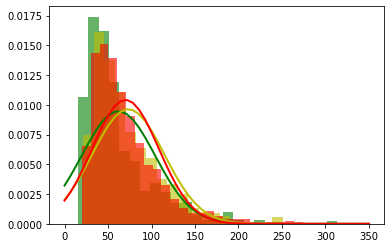

<ipython-input-46-a82febd698ac>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-46-a82febd698ac>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-46-a82febd698ac>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


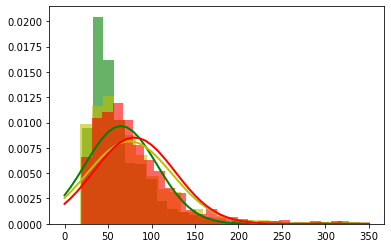

<ipython-input-46-a82febd698ac>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-46-a82febd698ac>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-46-a82febd698ac>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


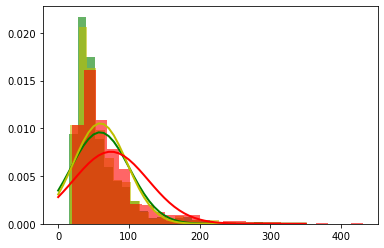

<ipython-input-46-a82febd698ac>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-46-a82febd698ac>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-46-a82febd698ac>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


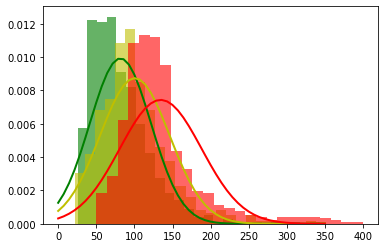

<ipython-input-46-a82febd698ac>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-46-a82febd698ac>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-46-a82febd698ac>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


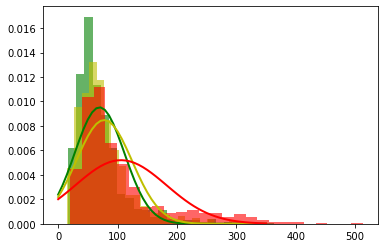

<ipython-input-46-a82febd698ac>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-46-a82febd698ac>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-46-a82febd698ac>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


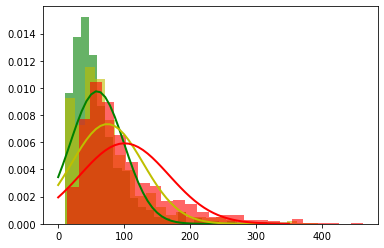

<ipython-input-46-a82febd698ac>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-46-a82febd698ac>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-46-a82febd698ac>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


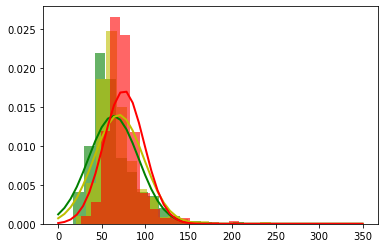

<ipython-input-46-a82febd698ac>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-46-a82febd698ac>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-46-a82febd698ac>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


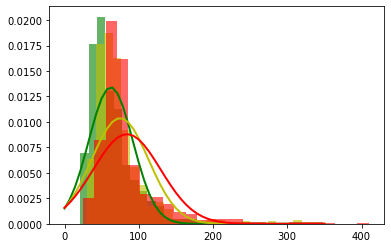

<ipython-input-46-a82febd698ac>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-46-a82febd698ac>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-46-a82febd698ac>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


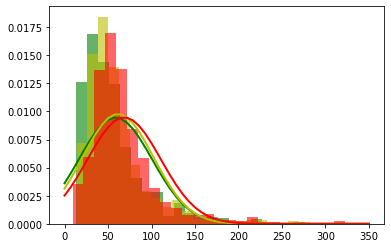

<ipython-input-46-a82febd698ac>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-46-a82febd698ac>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-46-a82febd698ac>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


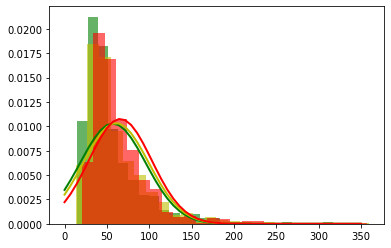

<ipython-input-46-a82febd698ac>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-46-a82febd698ac>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-46-a82febd698ac>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


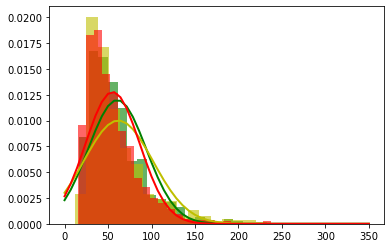

<ipython-input-46-a82febd698ac>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-46-a82febd698ac>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-46-a82febd698ac>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


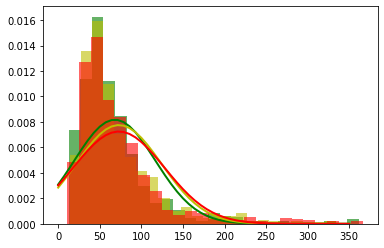

<ipython-input-46-a82febd698ac>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-46-a82febd698ac>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-46-a82febd698ac>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


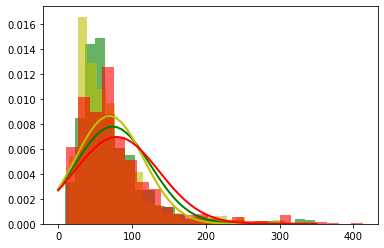

In [46]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

mu_2=np.zeros([13,3])
std_2=np.zeros([13,3])
for count,i in enumerate(letters):
    var1=i[0]
    var2=i[1]
    var3=i[2]
    # Plot the histogram.
    plt.hist(var1, bins=25, density=True, alpha=0.6, color='g')
    plt.hist(var2, bins=25, density=True, alpha=0.6, color='y')
    plt.hist(var3, bins=25, density=True, alpha=0.6, color='r')
    # Fit a normal distribution to the data:
    mu1, std1 = norm.fit(var1)
    mu2, std2 = norm.fit(var2)
    mu3, std3 = norm.fit(var3)
    mu_2[count]=[mu1,mu2,mu3]
    std_2[count]=[std1,std2,std3]
    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(0, 350)
    p1 = norm.pdf(x, mu1, std1)
    p2 = norm.pdf(x, mu2, std2)
    p3 = norm.pdf(x, mu3, std3)
    plt.plot(x, p1, 'k', linewidth=2,color='g')
    plt.plot(x, p2, 'k', linewidth=2,color='y')
    plt.plot(x, p3, 'k', linewidth=2,color='r')
    count2=str(count)
    plt.savefig('model_585_'+count2+'.png')
    plt.show()

In [47]:
#370
mu_1

array([[ 66.06196042,  64.15394638,  69.69732319],
       [ 62.11206912,  70.09769469,  77.48680048],
       [ 60.55406466,  59.81081546,  66.94638309],
       [ 78.35625697,  98.6455285 , 117.96066039],
       [ 66.16358082,  84.24353913,  95.22134251],
       [ 61.08470513,  71.85627778,  84.25883913],
       [ 66.21109643,  70.17088937,  77.70833333],
       [ 60.23877982,  68.10060725,  74.5028314 ],
       [ 61.16572018,  64.37291836,  71.13132174],
       [ 57.65664326,  64.72787536,  66.97261739],
       [ 62.40183501,  58.06749034,  58.69928841],
       [ 67.92549833,  69.71266039,  74.42916908],
       [ 70.81574638,  77.42072271,  78.72764203]])

In [48]:
#585
mu_2

array([[ 61.94480992,  73.29059179,  70.11904493],
       [ 64.85825195,  74.58882995,  80.13355362],
       [ 59.22813266,  59.45994976,  74.50112705],
       [ 81.65619621, 100.58100773, 134.48153478],
       [ 69.68289298,  77.36671353, 105.70635411],
       [ 59.08157191,  74.71425942, 100.55921546],
       [ 63.65177313,  69.73181159,  75.47254928],
       [ 62.2487447 ,  74.79928213,  84.02246522],
       [ 58.59629877,  61.56315169,  68.60068116],
       [ 57.12156856,  60.79413865,  65.88362899],
       [ 60.56508027,  61.85432657,  55.29857729],
       [ 68.12082887,  72.89573333,  72.96188357],
       [ 73.67207748,  69.4180372 ,  79.26197874]])

In [51]:
#370
std_1

array([[45.15077403, 35.18360324, 40.37835667],
       [40.87586178, 47.16463234, 59.88493405],
       [36.05379499, 42.17105747, 45.50423279],
       [44.3294077 , 47.88031546, 52.38370459],
       [36.3580313 , 50.89850503, 60.90950444],
       [45.59742695, 51.16889487, 58.02039423],
       [34.64121516, 31.15871455, 29.88288529],
       [32.04700303, 35.22153182, 29.81077061],
       [38.69804984, 46.13077149, 49.57280951],
       [34.28419334, 45.181514  , 40.32727656],
       [38.69525734, 40.61335038, 35.31106831],
       [42.91155839, 48.54274144, 54.24132856],
       [45.39093824, 51.12510991, 59.27299722]])

In [52]:
#585
std_2

array([[42.16256403, 41.43319927, 38.31183368],
       [41.33450243, 48.94832852, 46.8267015 ],
       [41.62374158, 37.90169776, 52.84519741],
       [40.18803842, 45.64784475, 53.66320211],
       [41.88169889, 47.00535963, 76.68283996],
       [40.88419545, 54.34853357, 67.36249036],
       [28.83675513, 28.53690843, 23.34684613],
       [29.75212109, 38.44594095, 45.35032115],
       [42.20993714, 40.81828002, 42.11296875],
       [38.76996087, 38.59640043, 37.06872047],
       [33.27082838, 39.87920487, 31.23164271],
       [48.81222763, 51.45116476, 55.0403265 ],
       [51.17095467, 46.12095617, 57.31049489]])

In [168]:
df4

,4,5,6,7,11,12,13,14,15,16,...,29,30,31,32,33,34,35,47,48,49
0,,,,,,,,,,,,,,,,,,,,,
0-0-0,72.875,72.875,72.875,72.875,73.125,73.125,73.125,73.125,73.125,73.125,...,73.375,73.375,73.375,73.375,73.375,73.375,73.375,73.625,73.625,73.625
0-0-0,19.375,19.625,19.875,20.125,18.375,18.625,18.875,19.125,19.375,19.625,...,18.625,18.875,19.125,19.375,19.625,19.875,20.125,19.375,19.625,20.125
2015-1-1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.410,0.000,0.000,0.230
2015-1-2,3.460,4.080,4.540,4.340,3.420,4.990,4.670,4.360,4.130,5.310,...,4.840,4.810,4.480,4.810,6.600,7.150,5.900,3.310,4.480,3.390
2015-1-3,3.870,4.520,4.840,4.460,4.170,5.730,5.220,4.520,4.100,5.020,...,5.130,4.780,4.210,4.100,5.200,5.500,4.420,2.760,3.360,2.250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2100-12-27,30.480,36.970,41.340,44.470,14.720,21.510,26.230,28.550,31.350,38.430,...,17.560,21.930,24.610,29.620,39.460,39.900,37.990,18.040,25.340,22.520
2100-12-28,30.020,32.470,33.330,32.990,30.240,34.180,32.590,31.010,30.050,33.710,...,26.250,26.080,25.690,27.540,33.910,32.070,28.490,16.990,21.750,16.880
2100-12-29,30.620,33.540,34.690,34.770,30.730,35.160,34.390,33.480,32.870,37.160,...,28.380,28.720,29.150,31.910,39.850,38.190,34.720,21.590,28.550,23.750


# Try 2

# Step1: make a raster for each day in the dataframe and export it

In [364]:
df1=dictionary_585['ACCESS-CM2-ssp585']
df2=dictionary_585['ACCESS-ESM1-5-ssp585']
df3=dictionary_585['BCC-CSM2-MR-ssp585']
df4=dictionary_585['CanESM5-ssp585']
df5=dictionary_585['EC-Earth3-ssp585']
df6=dictionary_585['EC-Earth3-Veg-ssp585']
df7=dictionary_585['INM-CM4-8-ssp585']
df8=dictionary_585['INM-CM5-0-ssp585']
df9=dictionary_585['MPI-ESM1-2-HR-ssp585']
df10=dictionary_585['MPI-ESM1-2-LR-ssp585']
df11=dictionary_585['MRI-ESM2-0-ssp585']
df12=dictionary_585['NorESM2-LM-ssp585']
df13=dictionary_585['NorESM2-MM-ssp585']

In [368]:
def func_make_raster(df,folder_name):
    #generate a list of coordinates present in the dataframe 
    longitudes=df.iloc[0]
    lattitudes=df.iloc[1]
    coordinates=np.vstack((longitudes, lattitudes)).T
    # make the framework for a raster
    rRes=0.25
    min_x=df.iloc[0].min()
    max_x=df.iloc[0].max()
    min_y=df.iloc[1].min()
    max_y=df.iloc[1].max()
    xrange=np.arange(min_x,max_x+rRes,rRes)
    yrange=np.arange(min_y,max_y+rRes,rRes)
    yrange_2=np.flip(yrange)
    gridX,gridY = np.meshgrid(xrange, yrange_2)
    #problem: we have raster with unprojected coordinates, hence we need to define the average width and height resolution and begin point(topleft) to export the raster
    #coordinates top left:
    longitude_top_left=df4.iloc[0].min()-0.125
    lattitude_top_left=df4.iloc[1].max()+0.125
    crs_wgs = proj.Proj('EPSG:4326') #were using WGS84 geographic
    crs_bng = proj.Proj('EPSG:32643')
    topleft_x, topleft_y = proj.transform(crs_wgs, crs_bng,lattitude_top_left,longitude_top_left)
    #average resolution:
    longitude_top_right=df4.iloc[0].max()+0.125
    lattitude_top_right=df4.iloc[1].max()+0.125
    topright_x, topright_y = proj.transform(crs_wgs, crs_bng,lattitude_top_right,longitude_top_right)
    res_width=(topright_x-topleft_x)/4
    longitude_bottom_left=df4.iloc[0].min()-0.125
    lattitude_bottom_left=df4.iloc[1].min()-0.125
    bottomleft_x, bottomleft_y = proj.transform(crs_wgs, crs_bng,lattitude_bottom_left,longitude_bottom_left)
    res_height=(topleft_y-bottomleft_y)/8
    #set-up projection variables
    path_projection = r'MMR_Area_and_SubBasins\mmr_boundary_raster_final.tif'
    open_projection=gdal.Open(path_projection)
    projection = open_projection.GetProjection()
    geotrans=(topleft_x, res_width,0.0,topleft_y,0.0,-res_height) 
    #fill in values into raster and export it
    for i in range(2,len(df)):
        values=list(df4.iloc[i])
        grid = griddata(coordinates, values, (gridX,gridY), method='nearest')
        outputPath = os.path.join(folder_name,df4.iloc[i].name +'.tif')
        cv2.imwrite(outputPath, grid)
        dataset2 = gdal.Open(outputPath, gdal.GA_Update)
        dataset2.SetGeoTransform(geotrans)
        dataset2.SetProjection(projection)

In [369]:
func_make_raster(df1,r'CMIP\model_1_rasters')

<ipython-input-368-922d879489c0>:22: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  topleft_x, topleft_y = proj.transform(crs_wgs, crs_bng,lattitude_top_left,longitude_top_left)
<ipython-input-368-922d879489c0>:26: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  topright_x, topright_y = proj.transform(crs_wgs, crs_bng,lattitude_top_right,longitude_top_right)
<ipython-input-368-922d879489c0>:30: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  bottomleft_x, bottomleft_y = proj.transform(crs_wgs, crs_bng,lattitude_bottom_left,longitude_bottom_left)


KeyboardInterrupt: 

# Step 2 link the rasters with the subbassins

In [372]:
#link raster data with the subbassins =, main
def func_link_subbassins(input_Folder,output_Folder):
    shapefile = gpd.read_file(r'MMR_Area_and_SubBasins\HECHMSTrial3_Subbasin_Boundaries_WGS84_V3.shp')
    geoms = shapefile.geometry.values # list of shapely geometries
    gdf2=pd.DataFrame()
    gdf2['name']=shapefile['name']
    for file in  os.listdir(input_Folder):
        if file.endswith('tif'):
            file_path=os.path.join(input_Folder, file)
            with rasterio.open(file_path) as src:
                affine = src.transform
                array = src.read(1)
                df_zonal_stats = pd.DataFrame(zonal_stats(geoms, array, affine=affine,all_touched=True))
            gdf2 = pd.concat([gdf2, df_zonal_stats['mean']], axis=1) 
            file=file.replace('.tif', '')
            gdf2 = gdf2.rename({'mean':file},axis=1) 
            parts = file.split("-")
            if str(parts[1])+"-"+str(parts[2])=='12-31':
                gdf2=gdf2.set_index('name')
                out_filename = parts[0] + ".csv"
                outputPath = os.path.join(output_Folder, out_filename)
                gdf2.to_csv(outputPath)
                gdf2=pd.DataFrame()
    return parts

In [373]:
func_link_subbassins(r'CMIP\model_1_rasters',r'CMIP\model_1_subbassins')

C:\Users\Quint\anaconda3\envs\gds\envs\myenv\lib\site-packages\rasterstats\io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


KeyboardInterrupt: 

In [378]:
#link raster data with the subbassins =, main
def func_link_MMR(input_Folder,output_Folder):
    counter = 0
    shapefile = gpd.read_file(r'MMR_Area_and_SubBasins\MMR_Area_Boundary_WGS84_proj.shp')
    geoms = shapefile.geometry.values # list of shapely geometries
    gdf2=pd.DataFrame()
    gdf2['name']=shapefile['name']
    for file in  os.listdir(input_Folder):
        if file.endswith('tif'):
            file_path=os.path.join(input_Folder, file)
            with rasterio.open(file_path) as src:
                affine = src.transform
                array = src.read(1)
                df_zonal_stats = pd.DataFrame(zonal_stats(geoms, array, affine=affine,all_touched=True))
            gdf2 = pd.concat([gdf2, df_zonal_stats['mean']], axis=1) 
            file=file.replace('.tif', '')
            gdf2 = gdf2.rename({'mean':file},axis=1) 
            parts = file.split("-")
            if str(parts[1])+"-"+str(parts[2])=='12-31':
                gdf2['name']='MMR'
                gdf2=gdf2.set_index('name')
                out_filename = parts[0] + ".csv"
                outputPath = os.path.join(output_Folder, out_filename)
                gdf2.to_csv(outputPath)
                gdf2=pd.DataFrame()

In [379]:
func_link_MMR(r'CMIP\model_1_rasters',r'CMIP\model_1_MMR')

C:\Users\Quint\anaconda3\envs\gds\envs\myenv\lib\site-packages\rasterio\__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


ValueError: negative dimensions are not allowed

# calculate final values

In [ ]:
#combine MMR and subbasin data, create total files
def func_combineren(inputFolder1,inputFolder2,outputFolder):
    for file in  os.listdir(inputFolder1):
            file_path1=os.path.join(inputFolder1, file)
            file_path2=os.path.join(inputFolder2, file)
            df1 = pd.read_csv(file_path1,index_col='name')
            df2 = pd.read_csv(file_path2,index_col='name')
            df3 = pd.concat([df1, df2], axis=0) 
            outputPath=os.path.join(outputFolder, file)
            df3.to_csv(outputPath)
            df3=pd.DataFrame()

In [ ]:
func_combineren(r'CMIP\model_1_subbassins',r'CMIP\model_1_MMR',r'CMIP\model_1_total')

In [ ]:
#calculate maximum rainfall
def func_max(inputFolder1,outputFolder):
    for file in  os.listdir(inputFolder1):
            file_path1=os.path.join(inputFolder1, file)
            df1 = pandas.read_csv(file_path1,index_col='name')
            df2=pd.DataFrame()
            df3=pd.DataFrame()
            df2['date']=df1.idxmax(axis=1)
            df3['rainfall']=df1.max(axis=1)
            c=pd.concat([df2,df3],axis=1)
            outputPath=os.path.join(outputFolder, file)
            c.to_csv(outputPath)

In [ ]:
func_max(r'CMIP\model_1_total',r'CMIP\model_1_max')

In [330]:
open_projection=gdal.Open(path_projection)
projection = open_projection.GetProjection()

In [338]:
longitudes=df4.iloc[0].min()-0.125
lattitudes=df4.iloc[1].max()+0.125
print(longitudes)

72.75


In [347]:
longitudes=df4.iloc[0].min()-0.125
lattitudes=df4.iloc[1].max()+0.125
# setup your projections
crs_wgs = proj.Proj('EPSG:4326') # assuming you're using WGS84 geographic
crs_bng = proj.Proj('EPSG:32643') # use a locally appropriate projected CRS

# then cast your geographic coordinate pair to the projected system
linksboven_x, linksboven_y = proj.transform(crs_wgs, crs_bng,lattitudes,longitudes)

<ipython-input-347-94081496f832>:8: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  linksboven_x, linksboven_y = proj.transform(crs_wgs, crs_bng,lattitudes,longitudes)


In [348]:
linksboven_x

264965.7900426765

In [349]:
linksboven_y

2240744.5656547076

In [350]:
geotrans_2=(linksboven_x, rRes_width,0.0,linksboven_y,0.0,-rRes_height) 

In [352]:
outputPath = os.path.join(r'CMIP\model_mean_585_single_3','test2.tif')
cv2.imwrite(outputPath, grid)
dataset2 = gdal.Open(outputPath, gdal.GA_Update)
dataset2.SetGeoTransform(geotrans_2)
dataset2.SetProjection(projection)

0

In [357]:
func_make_raster(df4)

array([[111.39, 114.6 , 101.75,  65.87],
       [115.8 , 121.2 , 109.94,  80.33],
       [114.94, 121.06, 115.16,  80.33],
       [113.83, 116.16, 104.12,  67.78],
       [122.66, 122.66, 103.32, 103.32],
       [137.03, 137.03, 115.34, 115.34],
       [140.18, 140.18, 116.33, 116.33],
       [136.65, 136.65, 121.06, 121.06]])

In [283]:
coordinates_2

array([[72.875, 19.375],
       [72.875, 19.625],
       [72.875, 19.875],
       [72.875, 20.125],
       [73.125, 18.375],
       [73.125, 18.625],
       [73.125, 18.875],
       [73.125, 19.125],
       [73.125, 19.375],
       [73.125, 19.625],
       [73.125, 19.875],
       [73.125, 20.125],
       [73.375, 18.375],
       [73.375, 18.625],
       [73.375, 18.875],
       [73.375, 19.125],
       [73.375, 19.375],
       [73.375, 19.625],
       [73.375, 19.875],
       [73.375, 20.125],
       [73.625, 19.375],
       [73.625, 19.625],
       [73.625, 20.125]])

In [271]:
coordinates_2=np.vstack((longitudes, lattitudes)).T
values=list(df4.iloc[212])
rRes=0.25
min_x=df4.iloc[0].min()
max_x=df4.iloc[0].max()
min_y=df4.iloc[1].min()
max_y=df4.iloc[1].max()
xrange=np.arange(min_x,max_x+rRes,rRes)
yrange=np.arange(min_y,max_y+rRes,rRes)
yrange_2=np.flip(yrange)
gridX,gridY = np.meshgrid(xrange, yrange_2)
grid = griddata(coordinates_2, values, (gridX,gridY), method='nearest')

In [287]:
grid

array([[111.39, 114.6 , 101.75,  65.87],
       [115.8 , 121.2 , 109.94,  80.33],
       [114.94, 121.06, 115.16,  80.33],
       [113.83, 116.16, 104.12,  67.78],
       [122.66, 122.66, 103.32, 103.32],
       [137.03, 137.03, 115.34, 115.34],
       [140.18, 140.18, 116.33, 116.33],
       [136.65, 136.65, 121.06, 121.06]])

## Step 1: Project the coordinates of the dataframe to Mumbai's coordinates and make coordinate lists which can be used to generate quare rasters

In [300]:
# project coordinates of dataframe to projection for Mumbai
def func_projecter(df):
    longitudes=df.iloc[0]
    longitudes_list=list(longitudes)
    lattitudes=df.iloc[1]
    lattitudes_list=list(lattitudes)
    coordinates=list(zip(lattitudes,longitudes))
    # setup your projections
    crs_wgs = proj.Proj('EPSG:4326') # assuming you're using WGS84 geographic
    crs_bng = proj.Proj('EPSG:32643') # use a locally appropriate projected CRS

    # then cast your geographic coordinate pair to the projected system
    x, y = proj.transform(crs_wgs, crs_bng,lattitudes_list,longitudes_list)
    coordinates=list(zip(x,y))
    return coordinates,x,y

In [301]:
coordinates,x,y=func_projecter(df4)

<ipython-input-300-82caf4a3ae90>:13: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = proj.transform(crs_wgs, crs_bng,lattitudes_list,longitudes_list)


In [302]:
#group them so that a square projected grid arrises
def grouper(iterable):
    prev = None
    group = []
    for item in iterable:
        if prev is None or item - prev <= 1000:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group

x_2=dict(enumerate(grouper(x), 1))
y_2=dict(enumerate(grouper(np.sort(y)), 1))

In [303]:
#make it square/rectangular after using the grouping
def make_square(coordinates_2,x,y):
    #first we compute the average values of the various clusters
    avgDict_x = {}
    for k,v in x_2.items():
        avgDict_x[k] = sum(v)/ float(len(v))
    avgDict_y = {}
    for k,v in y_2.items():
        avgDict_y[k] = sum(v)/ float(len(v))
    x_3=list(avgDict_x.values())
    y_3=list(avgDict_y.values())
    #coordinates_3 are the normalised coordinates
    coordinates_3 = list(itertools.product(x_3, y_3))
    #now we need to compair the original coordinates with the normalised coordinates and transfer them to the projected coordinate frame
    for j in range(len(coordinates_2)):    
        myList_x = [i[0] for i in coordinates_3]
        myNumber_x = coordinates_2[j][0]
        normalised_x=(min(myList_x, key=lambda x:abs(x-myNumber_x)))
        myList_y = [i[1] for i in coordinates_3]
        myNumber_y = coordinates_2[j][1]
        normalised_y=min(myList_y, key=lambda x:abs(x-myNumber_y))
        coordinates_2[j]=[normalised_x,normalised_y]
    new_x=[i[0] for i in coordinates_2]
    new_y=[i[1] for i in coordinates_2]
    return coordinates_2,new_x,new_y

In [304]:
coordinates_2,new_x,new_y=make_square(coordinates,x_2,y_2)

In [305]:
coordinates_2

[[277328.0523076577, 2143276.3853212954],
 [277328.0523076577, 2170950.2007771544],
 [277328.0523076577, 2198754.2042895183],
 [277328.0523076577, 2226299.921641571],
 [302935.13676762057, 2032569.7144313892],
 [302935.13676762057, 2060240.6163963731],
 [302935.13676762057, 2087912.1837408687],
 [302935.13676762057, 2115584.424106344],
 [302935.13676762057, 2143276.3853212954],
 [302935.13676762057, 2170950.2007771544],
 [302935.13676762057, 2198754.2042895183],
 [302935.13676762057, 2226299.921641571],
 [329216.43008592736, 2032569.7144313892],
 [329216.43008592736, 2060240.6163963731],
 [329216.43008592736, 2087912.1837408687],
 [329216.43008592736, 2115584.424106344],
 [329216.43008592736, 2143276.3853212954],
 [329216.43008592736, 2170950.2007771544],
 [329216.43008592736, 2198754.2042895183],
 [329216.43008592736, 2226299.921641571],
 [355896.12028744613, 2143276.3853212954],
 [355896.12028744613, 2170950.2007771544],
 [355896.12028744613, 2226299.921641571]]

In [192]:
df4.iloc[0].min()

72.875

In [215]:
df4.iloc[1]

4     19.375
5     19.625
6     19.875
7     20.125
11    18.375
12    18.625
13    18.875
14    19.125
15    19.375
16    19.625
17    19.875
18    20.125
28    18.375
29    18.625
30    18.875
31    19.125
32    19.375
33    19.625
34    19.875
35    20.125
47    19.375
48    19.625
49    20.125
Name: 0-0-0, dtype: float64

In [217]:
#make raster files for rainfall data 
def make_raster(df):
    longitudes=df.iloc[0]
    longitudes_list=list(longitudes)
    lattitudes=df.iloc[1]
    lattitudes_list=list(lattitudes)
    coordinates=list(zip(lattitudes,longitudes))
    rRes=0.25
    min_x=df.iloc[0].min()
    max_x=df.iloc[0].max()
    min_y=df.iloc[1].min()
    max_y=df.iloc[1].max()
    xrange=np.arange(min_x-0.5*rRes,max_x+0.5*rRes,rRes)
    yrange=np.arange(min_y-0.5*rRes,max_y+0.5*rRes,rRes)
    print(xrange)
    print(yrange)
    yrange_2=np.flip(yrange)
    #create arrays of x,y over the raster extension
    gridX,gridY = np.meshgrid(xrange, yrange_2)
    print(gridX,gridY)
    #path_projection = r'MMR_Area_and_SubBasins\mmr_boundary_raster_final.tif'
    #luc_DEM=gdal.Open(path_projection)
    #projection = luc_DEM.GetProjection()
    #linksboven_x=min(xrange)
    #linksboven_y=max(yrange)+rRes
    #geotrans_2=(linksboven_x, rRes,0.0,linksboven_y,0.0,-rRes) 
    for i in range(2,4):
        values2=list(df.iloc[i])
    #interpolate over the grid
        grid = griddata(coordinates, values2, (gridX,gridY), method='nearest')
        print(grid)
        #outputPath = r'CMIP\grid_2.tif'
        outputPath = os.path.join(r'CMIP\model_mean_585_single_2', df4.iloc[i].name +'.tif')
        cv2.imwrite(outputPath, grid)
        #dataset2 = gdal.Open(outputPath, gdal.GA_Update)
        #dataset2.SetGeoTransform(geotrans_2)
        #dataset2.SetProjection(projection)

In [281]:
df4.iloc[212]

4     113.83
5     114.94
6     115.80
7     111.39
11    136.65
12    140.18
13    137.03
14    122.66
15    116.16
16    121.06
17    121.20
18    114.60
28    121.06
29    116.33
30    115.34
31    103.32
32    104.12
33    115.16
34    109.94
35    101.75
47     67.78
48     80.33
49     65.87
Name: 2015-7-30, dtype: float64

In [282]:
longitudes=df4.iloc[0]
longitudes_list=list(longitudes)
lattitudes=df4.iloc[1]
lattitudes_list=list(lattitudes)
coordinates=list(zip(lattitudes,longitudes))
values=list(df4.iloc[212])
coordinates_2=np.vstack((longitudes, lattitudes)).T

In [283]:
coordinates_2

array([[72.875, 19.375],
       [72.875, 19.625],
       [72.875, 19.875],
       [72.875, 20.125],
       [73.125, 18.375],
       [73.125, 18.625],
       [73.125, 18.875],
       [73.125, 19.125],
       [73.125, 19.375],
       [73.125, 19.625],
       [73.125, 19.875],
       [73.125, 20.125],
       [73.375, 18.375],
       [73.375, 18.625],
       [73.375, 18.875],
       [73.375, 19.125],
       [73.375, 19.375],
       [73.375, 19.625],
       [73.375, 19.875],
       [73.375, 20.125],
       [73.625, 19.375],
       [73.625, 19.625],
       [73.625, 20.125]])

In [271]:
rRes=0.25
min_x=df4.iloc[0].min()
max_x=df4.iloc[0].max()
min_y=df4.iloc[1].min()
max_y=df4.iloc[1].max()
xrange=np.arange(min_x,max_x+rRes,rRes)
yrange=np.arange(min_y,max_y+rRes,rRes)
yrange_2=np.flip(yrange)
gridX,gridY = np.meshgrid(xrange, yrange_2)


In [286]:
grid = griddata(coordinates_2, values, (gridX,gridY), method='nearest')

In [287]:
grid

array([[111.39, 114.6 , 101.75,  65.87],
       [115.8 , 121.2 , 109.94,  80.33],
       [114.94, 121.06, 115.16,  80.33],
       [113.83, 116.16, 104.12,  67.78],
       [122.66, 122.66, 103.32, 103.32],
       [137.03, 137.03, 115.34, 115.34],
       [140.18, 140.18, 116.33, 116.33],
       [136.65, 136.65, 121.06, 121.06]])

In [325]:
coordinates_projected,new_x,new_y=make_square(coordinates,x_2,y_2)

In [326]:
width_cell=(max(new_x)-min(new_x))/(len(np.unique(new_x))-1)
height_cell=(max(new_y)-min(new_y))/(len(np.unique(new_y))-1)
    
rRes_width=width_cell
rRes_height=height_cell

In [327]:
print(rRes_width)

26189.3559932628


In [328]:
print(rRes_height)

27675.74388716882


In [329]:
path_projection = r'MMR_Area_and_SubBasins\mmr_boundary_raster_final.tif'

In [330]:
open_projection=gdal.Open(path_projection)
projection = open_projection.GetProjection()

In [338]:
longitudes=df4.iloc[0].min()-0.125
lattitudes=df4.iloc[1].max()+0.125
print(longitudes)

72.75


In [347]:
longitudes=df4.iloc[0].min()-0.125
lattitudes=df4.iloc[1].max()+0.125
# setup your projections
crs_wgs = proj.Proj('EPSG:4326') # assuming you're using WGS84 geographic
crs_bng = proj.Proj('EPSG:32643') # use a locally appropriate projected CRS

# then cast your geographic coordinate pair to the projected system
linksboven_x, linksboven_y = proj.transform(crs_wgs, crs_bng,lattitudes,longitudes)

<ipython-input-347-94081496f832>:8: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  linksboven_x, linksboven_y = proj.transform(crs_wgs, crs_bng,lattitudes,longitudes)


In [348]:
linksboven_x

264965.7900426765

In [349]:
linksboven_y

2240744.5656547076

In [350]:
geotrans_2=(linksboven_x, rRes_width,0.0,linksboven_y,0.0,-rRes_height) 

In [352]:
outputPath = os.path.join(r'CMIP\model_mean_585_single_3','test2.tif')
cv2.imwrite(outputPath, grid)
dataset2 = gdal.Open(outputPath, gdal.GA_Update)
dataset2.SetGeoTransform(geotrans_2)
dataset2.SetProjection(projection)

0

In [207]:
for i in range(218,220):
    input_Folder=r'CMIP\model_mean_585_single_2'
    file=os.listdir(input_Folder)[i]
    if file.endswith('tif'):
        file_path=os.path.join(input_Folder, file)
        with rasterio.open(file_path) as src:
            affine = src.transform
            array = src.read(1)

In [208]:
array

array([[54.6, 54.6, 54.6, 54.6],
       [54.6, 54.6, 54.6, 54.6],
       [54.6, 54.6, 54.6, 54.6],
       [54.6, 54.6, 54.6, 54.6],
       [54.6, 54.6, 54.6, 54.6],
       [54.6, 54.6, 54.6, 54.6],
       [54.6, 54.6, 54.6, 54.6],
       [54.6, 54.6, 54.6, 54.6]])

In [ ]:
#link raster data with the subbassins, trial 2
def func32_2(inputFolder,outputFolder):
    counter = 0
    shapefile = gpd.read_file(r'MMR_Area_and_SubBasins\HECHMSTrial3_Subbasin_Boundaries_WGS84_V2.shp')
    input_Folder = inputFolder
    #env.workspace = inputFolder
    output_Folder = outputFolder
    geoms = shapefile.geometry.values # list of shapely geometries
    gdf2=pd.DataFrame()
    gdf2['name']=shapefile['name']
    for i in range(0,2):
        file=os.listdir(input_Folder)[i]
        if file.endswith('tif'):
            file_path=os.path.join(input_Folder, file)
            with rasterio.open(file_path) as src:
                affine = src.transform
                array = src.read(1)
                df_zonal_stats = pd.DataFrame(zonal_stats(geoms, array, affine=affine,all_touched=True))
            gdf2 = pd.concat([gdf2, df_zonal_stats['mean']], axis=1) 
            file=file.replace('.tif', '')
            gdf2 = gdf2.rename({'mean':file},axis=1) 
            parts = file.split("-")
            if str(parts[1])+"-"+str(parts[2])=='12-31':
                gdf2=gdf2.set_index('name')
                out_filename = parts[0] + ".csv"
                outputPath = os.path.join(output_Folder, out_filename)
                gdf2.to_csv(outputPath)
                gdf2=pd.DataFrame()
                gdf2['name']=shapefile['name']
    return parts

In [ ]:
func32_2(r'CMIP\model_mean_585_single',r'CMIP\output_585_single_total')

# derive rainfall per location 

31.411 days: 1-1-2015 until 31-12-2100
31.390 days without schrikkeldagen

## Step 1: Project the coordinates of the dataframe to Mumbai's coordinates and make coordinate lists which can be used to generate quare rasters

In [300]:
# project coordinates of dataframe to projection for Mumbai
def func_projecter(df):
    longitudes=df.iloc[0]
    longitudes_list=list(longitudes)
    lattitudes=df.iloc[1]
    lattitudes_list=list(lattitudes)
    coordinates=list(zip(lattitudes,longitudes))
    # setup your projections
    crs_wgs = proj.Proj('EPSG:4326') # assuming you're using WGS84 geographic
    crs_bng = proj.Proj('EPSG:32643') # use a locally appropriate projected CRS

    # then cast your geographic coordinate pair to the projected system
    x, y = proj.transform(crs_wgs, crs_bng,lattitudes_list,longitudes_list)
    coordinates=list(zip(x,y))
    return coordinates,x,y

In [301]:
coordinates,x,y=func_projecter(df4)

<ipython-input-300-82caf4a3ae90>:13: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = proj.transform(crs_wgs, crs_bng,lattitudes_list,longitudes_list)


In [302]:
#group them so that a square projected grid arrises
def grouper(iterable):
    prev = None
    group = []
    for item in iterable:
        if prev is None or item - prev <= 1000:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group

x_2=dict(enumerate(grouper(x), 1))
y_2=dict(enumerate(grouper(np.sort(y)), 1))

In [303]:
#make it square/rectangular after using the grouping
def make_square(coordinates_2,x,y):
    #first we compute the average values of the various clusters
    avgDict_x = {}
    for k,v in x_2.items():
        avgDict_x[k] = sum(v)/ float(len(v))
    avgDict_y = {}
    for k,v in y_2.items():
        avgDict_y[k] = sum(v)/ float(len(v))
    x_3=list(avgDict_x.values())
    y_3=list(avgDict_y.values())
    #coordinates_3 are the normalised coordinates
    coordinates_3 = list(itertools.product(x_3, y_3))
    #now we need to compair the original coordinates with the normalised coordinates and transfer them to the projected coordinate frame
    for j in range(len(coordinates_2)):    
        myList_x = [i[0] for i in coordinates_3]
        myNumber_x = coordinates_2[j][0]
        normalised_x=(min(myList_x, key=lambda x:abs(x-myNumber_x)))
        myList_y = [i[1] for i in coordinates_3]
        myNumber_y = coordinates_2[j][1]
        normalised_y=min(myList_y, key=lambda x:abs(x-myNumber_y))
        coordinates_2[j]=[normalised_x,normalised_y]
    new_x=[i[0] for i in coordinates_2]
    new_y=[i[1] for i in coordinates_2]
    return coordinates_2,new_x,new_y

In [304]:
coordinates_2,new_x,new_y=make_square(coordinates,x_2,y_2)

In [305]:
coordinates_2

[[277328.0523076577, 2143276.3853212954],
 [277328.0523076577, 2170950.2007771544],
 [277328.0523076577, 2198754.2042895183],
 [277328.0523076577, 2226299.921641571],
 [302935.13676762057, 2032569.7144313892],
 [302935.13676762057, 2060240.6163963731],
 [302935.13676762057, 2087912.1837408687],
 [302935.13676762057, 2115584.424106344],
 [302935.13676762057, 2143276.3853212954],
 [302935.13676762057, 2170950.2007771544],
 [302935.13676762057, 2198754.2042895183],
 [302935.13676762057, 2226299.921641571],
 [329216.43008592736, 2032569.7144313892],
 [329216.43008592736, 2060240.6163963731],
 [329216.43008592736, 2087912.1837408687],
 [329216.43008592736, 2115584.424106344],
 [329216.43008592736, 2143276.3853212954],
 [329216.43008592736, 2170950.2007771544],
 [329216.43008592736, 2198754.2042895183],
 [329216.43008592736, 2226299.921641571],
 [355896.12028744613, 2143276.3853212954],
 [355896.12028744613, 2170950.2007771544],
 [355896.12028744613, 2226299.921641571]]

## Step 2: make raster files for each day of the rainfall data, hence for each row and export them

In [190]:
#make raster files for rainfall data 
def make_raster(new_x,new_y,df):
    width_cell=(max(new_x)-min(new_x))/(len(np.unique(new_x))-1)
    height_cell=(max(new_y)-min(new_y))/(len(np.unique(new_y))-1)
    
    rRes=(width_cell+height_cell)/2
    xrange=np.arange(min(new_x)-0.5*width_cell,max(new_x)+0.5*width_cell,rRes)
    yrange=np.arange(min(new_y)-0.5*height_cell,max(new_y)+0.5*height_cell,rRes)
    yrange_2=np.flip(yrange)
    #create arrays of x,y over the raster extension
    gridX,gridY = np.meshgrid(xrange, yrange_2)
    path_projection = r'MMR_Area_and_SubBasins\mmr_boundary_raster_final.tif'
    luc_DEM=gdal.Open(path_projection)
    projection = luc_DEM.GetProjection()
    linksboven_x=min(xrange)
    linksboven_y=max(yrange)+rRes
    geotrans_2=(linksboven_x, rRes,0.0,linksboven_y,0.0,-rRes) 
    for i in range(2,368):
        values2=list(df.iloc[i])
    #interpolate over the grid
        grid = griddata(coordinates_2, values2, (gridX,gridY), method='nearest')
        #outputPath = r'CMIP\grid_2.tif'
        outputPath = os.path.join(r'CMIP\model_mean_585_single_2', df4.iloc[i].name +'.tif')
        cv2.imwrite(outputPath, grid)
        dataset2 = gdal.Open(outputPath, gdal.GA_Update)
        dataset2.SetGeoTransform(geotrans_2)
        dataset2.SetProjection(projection)

In [191]:
make_raster(new_x,new_y,df4)

In [185]:
df.iloc[212]

0      2015.00
1         7.00
2        29.00
3        50.19
4        77.15
        ...   
117       1.63
118       0.81
119       1.24
120       0.12
121       0.00
Name: 212, Length: 122, dtype: float64

In [177]:
df4.iloc[212]

4     113.83
5     114.94
6     115.80
7     111.39
11    136.65
12    140.18
13    137.03
14    122.66
15    116.16
16    121.06
17    121.20
18    114.60
28    121.06
29    116.33
30    115.34
31    103.32
32    104.12
33    115.16
34    109.94
35    101.75
47     67.78
48     80.33
49     65.87
Name: 2015-7-30, dtype: float64

In [167]:
coordinates

[(277328.0523076577, 2143276.3853212954),
 (277328.0523076577, 2170950.2007771544),
 (277328.0523076577, 2198754.2042895183),
 (277328.0523076577, 2226299.921641571),
 (302935.13676762057, 2032569.7144313892),
 (302935.13676762057, 2060240.6163963731),
 (302935.13676762057, 2087912.1837408687),
 (302935.13676762057, 2115584.424106344),
 (302935.13676762057, 2143276.3853212954),
 (302935.13676762057, 2170950.2007771544),
 (302935.13676762057, 2198754.2042895183),
 (302935.13676762057, 2226299.921641571),
 (329216.43008592736, 2032569.7144313892),
 (329216.43008592736, 2060240.6163963731),
 (329216.43008592736, 2087912.1837408687),
 (329216.43008592736, 2115584.424106344),
 (329216.43008592736, 2143276.3853212954),
 (329216.43008592736, 2170950.2007771544),
 (329216.43008592736, 2198754.2042895183),
 (329216.43008592736, 2226299.921641571),
 (355896.12028744613, 2143276.3853212954),
 (355896.12028744613, 2170950.2007771544),
 (355896.12028744613, 2226299.921641571)]

## Step 3: link raster rainfall data with the subbassins

In [9]:
#link raster data with the subbassins, trial 2
def func32_2(inputFolder,outputFolder):
    counter = 0
    shapefile = gpd.read_file(r'MMR_Area_and_SubBasins\HECHMSTrial3_Subbasin_Boundaries_WGS84_V3.shp')
    input_Folder = inputFolder
    #env.workspace = inputFolder
    output_Folder = outputFolder
    geoms = shapefile.geometry.values # list of shapely geometries
    gdf2=pd.DataFrame()
    gdf2['name']=shapefile['name']
    for i in range(31026,len(os.listdir(input_Folder))):
        file=os.listdir(input_Folder)[i]
        if file.endswith('tif'):
            file_path=os.path.join(input_Folder, file)
            with rasterio.open(file_path) as src:
                affine = src.transform
                array = src.read(1)
                df_zonal_stats = pd.DataFrame(zonal_stats(geoms, array, affine=affine,all_touched=True))
            gdf2 = pd.concat([gdf2, df_zonal_stats['mean']], axis=1) 
            file=file.replace('.tif', '')
            gdf2 = gdf2.rename({'mean':file},axis=1) 
            parts = file.split("-")
            if str(parts[1])+"-"+str(parts[2])=='12-31':
                gdf2=gdf2.set_index('name')
                out_filename = parts[0] + ".csv"
                outputPath = os.path.join(output_Folder, out_filename)
                gdf2.to_csv(outputPath)
                gdf2=pd.DataFrame()
                gdf2['name']=shapefile['name']
    return parts


In [10]:
func32_2(r'CMIP\model_mean_585_single',r'CMIP\output_585_single_total')

['2100', '12', '31']

In [353]:
#link raster data with the subbassins =, main
def func32(inputFolder,outputFolder):
    counter = 0
    shapefile = gpd.read_file(r'MMR_Area_and_SubBasins\MMR_Area_Boundary_WGS84_proj.shp')
    input_Folder = inputFolder
    #env.workspace = inputFolder
    output_Folder = outputFolder
    geoms = shapefile.geometry.values # list of shapely geometries
    gdf2=pd.DataFrame()
    gdf2['name']=shapefile['name']
    for file in  os.listdir(inputFolder):
        if file.endswith('tif'):
            file_path=os.path.join(input_Folder, file)
            with rasterio.open(file_path) as src:
                affine = src.transform
                array = src.read(1)
                df_zonal_stats = pd.DataFrame(zonal_stats(geoms, array, affine=affine,all_touched=True))
            gdf2 = pd.concat([gdf2, df_zonal_stats['mean']], axis=1) 
            file=file.replace('.tif', '')
            gdf2 = gdf2.rename({'mean':file},axis=1) 
            parts = file.split("-")
            if str(parts[1])+"-"+str(parts[2])=='12-31':
                gdf2['name']='MMR'
                gdf2=gdf2.set_index('name')
                out_filename = parts[0] + ".csv"
                outputPath = os.path.join(output_Folder, out_filename)
                gdf2.to_csv(outputPath)
                gdf2=pd.DataFrame()
    return parts

In [354]:
func32(r'CMIP\model_mean_585_single',r'CMIP\output_585_single')

C:\Users\Quint\anaconda3\envs\gds\envs\myenv\lib\site-packages\rasterstats\io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


['2100', '12', '31']

In [76]:
#run13-8
func32(r'CMIP\model_mean-585',r'CMIP\output_585_MMR')

['2100', '12', '31']

In [29]:
#combineren_kan_je_leren, create total files
def func_combineren(inputFolder1,inputFolder2,outputFolder):
    for file in  os.listdir(inputFolder1):
            file_path1=os.path.join(inputFolder1, file)
            file_path2=os.path.join(inputFolder2, file)
            df1 = pd.read_csv(file_path1,index_col='name')
            df2 = pd.read_csv(file_path2,index_col='name')
            df3 = pd.concat([df1, df2], axis=0) 
            outputPath=os.path.join(outputFolder, file)
            df3.to_csv(outputPath)
            df3=pd.DataFrame()

In [30]:
func_combineren(r'CMIP\output_585_single',r'CMIP\output_585_single_MMR',r'CMIP\output_585_single_total')

In [127]:
#calculate maximum rainfall
def func_max(inputFolder1,outputFolder):
    for file in  os.listdir(inputFolder1):
            file_path1=os.path.join(inputFolder1, file)
            df1 = pandas.read_csv(file_path1,index_col='name')
            df2=pd.DataFrame()
            df3=pd.DataFrame()
            df2['date']=df1.idxmax(axis=1)
            df3['rainfall']=df1.max(axis=1)
            c=pd.concat([df2,df3],axis=1)
            outputPath=os.path.join(outputFolder, file)
            c.to_csv(outputPath)

In [128]:
func_max(r'CMIP\output_370_total',r'CMIP\output_370_max')
func_max(r'CMIP\output_585_total',r'CMIP\output_585_max')

In [72]:
#divide by 24 total
def func_d24(inputFolder,outputFolder):
    for file in os.listdir(inputFolder):
        file_path=os.path.join(inputFolder, file) 
        df1 = pandas.read_csv(file_path,index_col='name')
        df1=df1/24
        outputPath=os.path.join(outputFolder, file)
        df1.to_csv(outputPath)

In [73]:
func_d24(r'CMIP\output_370_total', r'CMIP\output_370_total_2')

In [74]:
func_d24(r'CMIP\output_585_total', r'CMIP\output_585_total_2')

In [83]:
#divide by 24 max
def func_d24_max(inputFolder,outputFolder):
    for file in os.listdir(inputFolder):
        file_path=os.path.join(inputFolder, file) 
        df1 = pandas.read_csv(file_path,index_col='name')
        df1['rainfall']=df1['rainfall']/24
        outputPath=os.path.join(outputFolder, file)
        df1.to_csv(outputPath)

In [84]:
func_d24_max(r'CMIP\output_370_max', r'CMIP\output_370_max_2')

In [86]:
func_d24_max(r'CMIP\output_585_max', r'CMIP\output_585_max_2')